In [1]:
from root_converter import *
import matplotlib.pyplot as plt
import glob
import matplotlib.dates as mdates

%config inlinebackend.figure_format = 'retina'
plt.style.use("/home/xishui/Projects/corsika_wrapper/presentation.mplstyle")

This notebook provides a demo of how to plot the GP13 data in 10-s trigger mode.

## Read root files to numpy array

In [2]:
fname_list = glob.glob("../TD/Calibration_0dB_XY_5Dus_GRAND.TEST-RAW.2023031[3,4,5]*.root")

In [3]:
# Notes on the shape of traces:
# the trace array has the shape of (# of triggers, # of channels, # of points for one trace)
# Example: (10000, 4, 1024) stands for 10000 times of triggers, 4 channels, 1024 points for each trace 
trigger_arr = root_reader(fname_list)
np.save("trigger_arr.20230313_20230315.npy", trigger_arr)

### Filtering

Though the data has been filtered according to the wrong trace length and ADC counts,
there are still some gliches which is not proper in the following analysis.  
Here, we just remove all the unwanted triggers according to the du_datetime. 

In [149]:
mask_DU1081 = ((trigger_arr["du_id"] == 1080)
               & (trigger_arr["du_datetime"] > np.datetime64('2023-03-12'))
              & (trigger_arr["du_datetime"] < np.datetime64('2023-03-16')))

## Mean ADC vs. Time

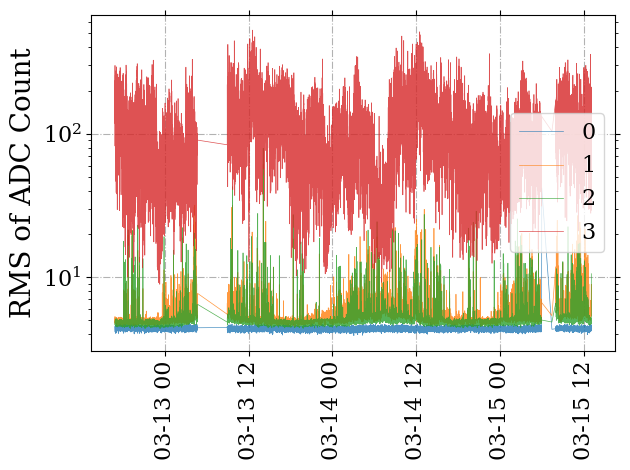

In [150]:
time_sort_arg = np.argsort(trigger_arr["du_datetime"][mask_DU1081])
for i in range(4):
    plt.plot(trigger_arr["du_datetime"][mask_DU1081][time_sort_arg],
             np.sqrt(np.mean((trigger_arr["trace"][mask_DU1081][:,i,:][time_sort_arg])**2, axis=1)),
            lw=.5, label=f'{i}', alpha=.8)
plt.legend()
plt.semilogy()
plt.xticks(rotation=90)
plt.grid(True)
plt.ylabel("RMS of ADC Count")
plt.tight_layout()
plt.savefig("RMS_0313_0315.png", dpi=400);

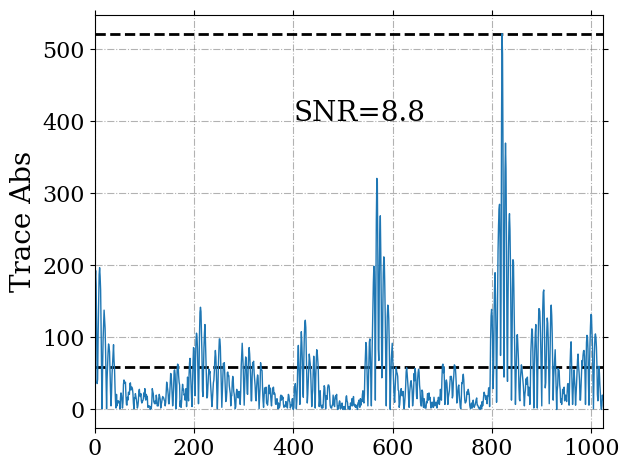

In [173]:
plt.plot(np.abs(trigger_arr["trace"][mask_DU1081][-1,3,:]),lw=1)
plt.hlines([trace_j_rms, peak_value], 0, 1024, color='k', ls='--')
plt.text(400, 400, f"SNR={peak_value / trace_j_rms:.1f}", fontsize=20)
plt.grid(True)
plt.xlim(0, 1024)
plt.ylabel("Trace Abs")
plt.tight_layout()
plt.savefig("SNR_demo.png", dpi=400)

## FFT vs Time

In [151]:
fft_arr = fft(trigger_arr['trace'], axis=2)

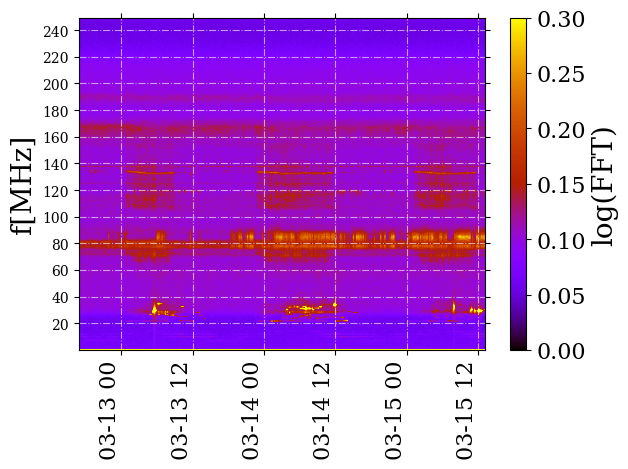

In [ ]:
mdate_num = mdates.date2num(trigger_arr["du_datetime"][mask_DU1081][time_sort_arg])
img = plt.imshow(np.log10(np.abs(fft_arr[:,1,:512][mask_DU1081][time_sort_arg]) * 2 / 1024 + 1e0).T,
           origin="lower", aspect='auto', cmap='gnuplot', extent=[mdate_num[0], mdate_num[-1],
                                                                  trace_f[0], trace_f[-1]],
                vmin=0.0, vmax=0.3)
cb_ax = plt.colorbar(label='log(FFT)', extend='neither')
ax = plt.gca()
plt.yticks(np.arange(20, 250, 20), fontsize=10)
date_format = mdates.DateFormatter('%m-%d %H')
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_format)
plt.grid(True, color='w')
# This simply sets the x-axis data to diagonal so it fits better.
plt.gcf().autofmt_xdate(rotation=90)
plt.ylabel("f[MHz]")
plt.tight_layout()
plt.savefig("FFT_0313_0315.png", dpi=400)

## Trigger rate of events with SNR>5

In [165]:
# Find the peak of each trace for each channel
trace_peak_above_SNR = np.zeros((np.sum(mask_DU1081), 4), float)

for i, trigger in enumerate(trigger_arr["trace"][mask_DU1081]):
    for j in range(4):
        peak_index = np.argmax(np.abs(trigger[j]))
        peak_value = np.max(np.abs(trigger[j]))
        # Set the window width of peak
        peak_index_lower = np.max([0, peak_index - 50])
        peak_index_upper = np.min([peak_index + 50, 1023])
        mask_non_peak = np.ones(1024, bool)
        mask_non_peak[peak_index_lower:peak_index_upper] = 0
        # Calculate RMS of each trace after excluding the peak
        trace_j_rms = np.sqrt(np.mean((trigger[j][mask_non_peak])**2))
        trace_peak_above_SNR[i,j] = peak_value / trace_j_rms

In [117]:
# The fraction of triggers with SNR > 5
frac_5SNR = np.sum(np.sum(trace_peak_above_SNR > 5, axis=1) > 0) / trace_peak_above_SNR.shape[0]

In [118]:
# The rate of events with SNR > 5, only x&y directions
np.sum(np.sum(trace_peak_above_SNR[:,1:3] > 5, axis=1) > 1) / (1024 * 1/500e6 * trace_peak_above_SNR.shape[0])

32845.488577835

In [167]:
test_SNR = np.linspace(3, 15, 50)
test_rate = (np.array([np.sum(np.sum(trace_peak_above_SNR[:,1:3] > i, axis=1) > 0) for i in test_SNR])
            / (1024 * 1/500e6 * trace_peak_above_SNR.shape[0]))

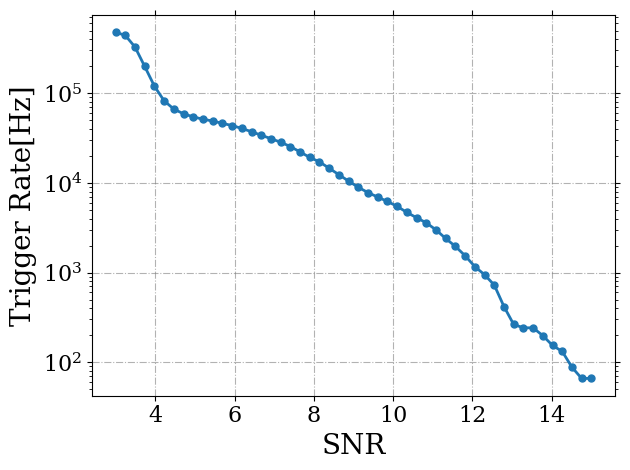

In [169]:
plt.semilogy(test_SNR, test_rate, marker='.')
plt.grid(True)
plt.xlabel("SNR")
plt.ylabel("Trigger Rate[Hz]")
plt.tight_layout()
# plt.savefig("SNR_0313_0315_DU80.png", dpi=400);

[]

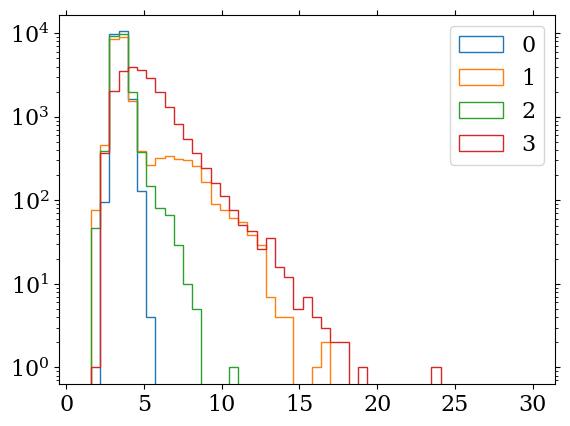

In [183]:
test_SNR_bin = np.linspace(1, 30)
plt.hist(trace_peak_above_SNR[:,0].flatten(), test_SNR_bin, histtype='step', label='0');
plt.hist(trace_peak_above_SNR[:,1].flatten(), test_SNR_bin, histtype='step', label='1');
plt.hist(trace_peak_above_SNR[:,2].flatten(), test_SNR_bin, histtype='step', label='2');
plt.hist(trace_peak_above_SNR[:,3].flatten(), test_SNR_bin, histtype='step', label='3');
plt.legend()
plt.semilogy()